## Load data.

In [1]:
import numpy as np
import os
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

from helper_functions import reverse_dict_list, reverse_dict_val, sorted_dict


CWD = os.path.abspath("")  # Jupyter notebook path.
dir_TEMP = os.path.join(CWD, "TEMP")  # Intermediate files.
dir_dict = os.path.join(CWD, "dicts")  # Data to plot.
dir_input = os.path.join(CWD, "input")
dir_output = os.path.join(CWD, "output")  # Folder to put figures in.
dir_npy = os.path.join(CWD, "npy")  # Data files needed for plotting figures.

# Set up plotting parameters.
cm_max = 15  # Maximum number of citation mentions to plot.
sent_colors = ["#504DB2", "#414042", "#B2504D"]  # POS, NEU, NEG
font_kw = {"family": "arial", "weight": "normal", "size": "7"}  # Markers and such.
mpl.rc("font", **font_kw)

# Load data to plot.
with open(os.path.join(dir_TEMP, "cite2sent_0.pkl"), "rb") as f:
    cite2sent_0 = pickle.load(f)  # Pre-aggregation citation sentences indices.
with open(os.path.join(dir_TEMP, "cite2sent_1.pkl"), "rb") as f:
    cite2sent_1 = pickle.load(f)  # Pre-aggregation citation sentiment.
with open(os.path.join(dir_TEMP, "sentences2rate-CGPT.txt"), mode="r+", encoding="UTF-8") as file_out:
    sentences2rate = file_out.readlines()
with open(os.path.join(dir_TEMP, "cite2ns.pkl"), "rb") as f:
    cite2ns = pickle.load(f)  # Citation frequency between a given citer-citee pair.
with open(os.path.join(dir_dict, "cite2sent_2.pkl"), "rb") as f:
    cite2sent_emp = pickle.load(f)  # Each citation pair has just 1 sentiment; "empirical".
with open(os.path.join(dir_dict, "paper2meta.pkl"), "rb") as f:
    paper2meta = pickle.load(f)
with open(os.path.join(dir_dict, "jour2meta.pkl"), "rb") as f:
    jour2meta = pickle.load(f)
with open(os.path.join(dir_dict, "cite2distance.pkl"), "rb") as f:
    cite2distance = pickle.load(f)  # Collaboration distance.

### brilliance department name matching prints.

In [2]:
with open(os.path.join(dir_dict, "paper2last_author_department_28_dep.pkl"), "rb") as f:
    paper2last_author_department = pickle.load(f)

departments_subset = set(reverse_dict_list(paper2last_author_department))
print(f"{len(departments_subset)} departments.")

df_fab = pd.read_csv(os.path.join(dir_input, "brilliance_data.csv"), on_bad_lines="skip", header=0)
dep2fab_field_label = {d: set() for d in departments_subset}
### Below aren't found in the brilliance .csv fields:
### "imaging", "mental", "radiology", "behavior", "therapy", "biomedical"
for x in sorted(list(set(df_fab["field_label"]))):
    x_lowercase = x.casefold()
    if x_lowercase in departments_subset:
        dep2fab_field_label[x_lowercase].add(x)
    elif x in {"MolecularBiology"}:
        dep2fab_field_label["molecular"].add(x)
    elif x in {"AnatomicClinicalPathology"}:
        dep2fab_field_label["pathology"].add(x)
    elif x in {"MedicalGenetics"}:
        dep2fab_field_label["medical"].add(x)
        dep2fab_field_label["genetics"].add(x)
    elif x in {"EmergencyMedicine", "FamilyMedicine", "InternalMedicine", "NuclearMedicine", "PainMedicine"}:
        dep2fab_field_label["medical"].add(x)
    elif x in {"InformationScience"}:
        dep2fab_field_label["information"].add(x)
    elif x in {"Anatomy/CellBiology"}:
        dep2fab_field_label["anatomy"].add(x)
        dep2fab_field_label["cell"].add(x)
    elif x in {"Pharmacology"}:
        dep2fab_field_label["pharma"].add(x)
    elif x in {"ColonRectalSurgery", "GeneralSurgery", "NeurologicalSurgery", "OrthopaedicSurgery", "PlasticSurgery", "ThoracicSurgery"}:
        dep2fab_field_label["surgery"].add(x)
    elif x in {"ComputerScience"}:
        dep2fab_field_label["compute"].add(x)

dep2fab_field_label = sorted_dict(dep2fab_field_label, reverse=False, key=lambda x:x[0])

28 departments.


In [3]:
for k,v in dep2fab_field_label.items():
    v_str = "N/A" if not v else ",".join(v)
    print(f"{k:<15s}{v_str:>150s}")

anatomy                                                                                                                                           Anatomy/CellBiology
behavior                                                                                                                                                          N/A
biochemistry                                                                                                                                             Biochemistry
biology                                                                                                                                                       Biology
biomedical                                                                                                                                                        N/A
cell                                                                                                                                              Anatomy/CellBiology
comp

### Sentences of each rated sentiment.

In [3]:
sentences = {1: [], 0: [], -1: []}
for pair in cite2sent_0:
    for idx, sentiment in zip(cite2sent_0[pair], cite2sent_1[pair]):
        sentences[sentiment].append(sentences2rate[idx].strip())

### h-Index stats.

In [2]:
with open(os.path.join(dir_dict, "last_author2hIndex.pkl"), "rb") as f:
    last_author2hIndex = pickle.load(f)
with open(os.path.join(dir_dict, "paper2last_author.pkl"), "rb") as f:
    paper2last_author = pickle.load(f)


last_authors = {au for au in paper2last_author.values()}
presence = {au for au in last_authors if au in last_author2hIndex}
a = len(presence) / len(last_authors) * 100
print(f"Num of last authors: {len(last_authors)} {a:.2f}")

Num of last authors: 56034 69.24


### Collab groups aggregate behavior stats.

In [2]:
# 4 collab distance types; [1, inf), [1], [2, inf), [0].
ratio_mat_rel = np.load(os.path.join(dir_npy, "ratio_mat_rel-collab_groups.npy"))

In [3]:
fav_to_collab = ratio_mat_rel[1, 0, :]  # distance [1]
fav_to_noncollab = ratio_mat_rel[2, 0, :]  # distance [2, inf)
print(f"{np.nanmean(fav_to_collab):.1f}")
print(f"{np.nanmean(fav_to_noncollab):.1f}")

16.8
-3.4


### Calculate pre-aggregation sentiment ratio (of citer-citee pairs) for research, review, and both types of papers.

In [4]:
research_POS = sum([sum([x == 1 for x in s]) for e, s in cite2sent_1.items() if paper2meta[e[0]]["article-type"] == "research-article"])
research_NEU = sum([sum([x == 0 for x in s]) for e, s in cite2sent_1.items() if paper2meta[e[0]]["article-type"] == "research-article"])
research_NEG = sum([sum([x == -1 for x in s]) for e, s in cite2sent_1.items() if paper2meta[e[0]]["article-type"] == "research-article"])
research_tot = research_POS + research_NEU + research_NEG
review_POS = sum([sum([x == 1 for x in s]) for e, s in cite2sent_1.items() if paper2meta[e[0]]["article-type"] == "review-article"])
review_NEU = sum([sum([x == 0 for x in s]) for e, s in cite2sent_1.items() if paper2meta[e[0]]["article-type"] == "review-article"])
review_NEG = sum([sum([x == -1 for x in s]) for e, s in cite2sent_1.items() if paper2meta[e[0]]["article-type"] == "review-article"])
review_tot = review_POS + review_NEU + review_NEG
x_POS = sum([sum([x == 1 for x in s]) for e, s in cite2sent_1.items()])
x_NEU = sum([sum([x == 0 for x in s]) for e, s in cite2sent_1.items()])
x_NEG = sum([sum([x == -1 for x in s]) for e, s in cite2sent_1.items()])
x_tot = x_POS + x_NEU + x_NEG

ratios = [
    [research_POS / research_tot * 100, review_POS / review_tot * 100, x_POS / x_tot * 100],
    [research_NEU / research_tot * 100, review_NEU / review_tot * 100, x_NEU / x_tot * 100],
    [research_NEG / research_tot * 100, review_NEG / review_tot * 100, x_NEG / x_tot * 100],
]
for r, s in zip(ratios, ["POS", "NEU", "NEG"]):
    print(f"{s} ratios: research {r[0]:.2f}% review {r[1]:.2f}% both {r[2]:.2f}%")

POS ratios: research 40.52% review 28.56% both 37.33%
NEU ratios: research 53.96% review 66.75% both 57.37%
NEG ratios: research 5.52% review 4.69% both 5.30%


### Calculate post-aggregation sentiment ratio (of citer-citee pairs) for research, review, and both types of papers.

In [5]:
research_POS = sum([s == 1 for e, s in cite2sent_emp.items() if paper2meta[e[0]]["article-type"] == "research-article"])
research_NEU = sum([s == 0 for e, s in cite2sent_emp.items() if paper2meta[e[0]]["article-type"] == "research-article"])
research_NEG = sum([s == -1 for e, s in cite2sent_emp.items() if paper2meta[e[0]]["article-type"] == "research-article"])
research_tot = research_POS + research_NEU + research_NEG
review_POS = sum([s == 1 for e, s in cite2sent_emp.items() if paper2meta[e[0]]["article-type"] == "review-article"])
review_NEU = sum([s == 0 for e, s in cite2sent_emp.items() if paper2meta[e[0]]["article-type"] == "review-article"])
review_NEG = sum([s == -1 for e, s in cite2sent_emp.items() if paper2meta[e[0]]["article-type"] == "review-article"])
review_tot = review_POS + review_NEU + review_NEG
x_POS = sum([s == 1 for e, s in cite2sent_emp.items()])
x_NEU = sum([s == 0 for e, s in cite2sent_emp.items()])
x_NEG = sum([s == -1 for e, s in cite2sent_emp.items()])
x_tot = x_POS + x_NEU + x_NEG

ratios = [
    [research_POS / research_tot * 100, review_POS / review_tot * 100, x_POS / x_tot * 100],
    [research_NEU / research_tot * 100, review_NEU / review_tot * 100, x_NEU / x_tot * 100],
    [research_NEG / research_tot * 100, review_NEG / review_tot * 100, x_NEG / x_tot * 100],
]
for r, s in zip(ratios, ["POS", "NEU", "NEG"]):
    print(f"{s} ratios: research {r[0]:.2f}% review {r[1]:.2f}% both {r[2]:.2f}%")

POS ratios: research 44.71% review 35.64% both 42.21%
NEU ratios: research 46.92% review 57.57% both 49.85%
NEG ratios: research 8.37% review 6.79% both 7.94%


### Make journal table (only ones ended up in the analysis).

In [2]:
# Set of journals in the data.
journals_s = {v["jyf"][0] for v in paper2meta.values()}
# jour2meta has all 185+3 considered and 184+3=187 found in Medline.
# In final data, there are 181 journals.
print(len(journals_s), len(jour2meta))

for k in jour2meta:
    if jour2meta[k]["MedAbbr"] not in journals_s:
        # print(jour2meta[k]["MedAbbr"], jour2meta[k]["jourMeta"]["OAGoldPercent"])
        pass

# Find papers in each journal.
jour2paper = {j: set() for j in journals_s}
for p, v in paper2meta.items():
    jour2paper[v["jyf"][0]].add(p)

181 187


In [3]:
# Print journal table.
jour2meta_sorted = dict(
    sorted(dict(i for i in jour2meta.items() if i[1]["MedAbbr"] in journals_s).items(), key=lambda kv: kv[1]["JournalTitle"].casefold())
)


print(max([len(v["JournalTitle"]) for v in jour2meta_sorted.values()]))
print(f"{'Journal Title':<132s}{'JIF':>10s}{'% OA Gold':>12s}{'Number of Papers in Analysis':>30s}")
bb = [None] * len(jour2meta_sorted)
cc = [None] * len(jour2meta_sorted)
dd = [None] * len(jour2meta_sorted)
for i, k in enumerate(jour2meta_sorted):
    a = jour2meta_sorted[k]["JournalTitle"]
    b = jour2meta_sorted[k]["jourMeta"]["JIF2022"]
    c = jour2meta_sorted[k]["jourMeta"]["OAGoldPercent"]
    d = len(jour2paper[jour2meta_sorted[k]["MedAbbr"]])
    bb[i] = b
    cc[i] = c
    dd[i] = d
    print(f"{a:<132s}{b:>10}{c:>12}{d:>30}")
print(f"{'Journal Average':<132s}{np.mean(bb):>10.1f}{np.mean(cc):>12.2f}{np.mean(dd):>30.3f}")
print(f"{'Journal Standard Deviation':<132s}{np.std(bb):>10.1f}{np.std(cc):>12.2f}{np.std(dd):>30.3f}")

131
Journal Title                                                                                                                              JIF   % OA Gold  Number of Papers in Analysis
ACS chemical neuroscience                                                                                                                    5       13.11                           251
Acta neuropathologica                                                                                                                     12.7       60.92                           643
Acta neuropathologica communications                                                                                                       7.1       99.82                          1445
Acta neuropsychiatrica                                                                                                                     3.8       25.98                             1
Alzheimer's & dementia (Amsterdam, Netherlands)                        

### Make department table (all 28 considered).

In [2]:
with open(os.path.join(dir_dict, "paper2last_author.pkl"), "rb") as f:
    paper2last_author = pickle.load(f)
with open(os.path.join(dir_dict, "paper2first_author.pkl"), "rb") as f:
    paper2first_author = pickle.load(f)
last_author2paper = reverse_dict_val(paper2last_author)
first_author2paper = reverse_dict_val(paper2first_author)

with open(os.path.join(dir_dict, "paper2last_author_department_28_dep.pkl"), "rb") as f:
    paper2last_author_department = pickle.load(f)  # Last author departments for each paper.
with open(os.path.join(dir_dict, "paper2first_author_department_28_dep.pkl"), "rb") as f:
    paper2first_author_department = pickle.load(f)  # First author departments for each paper.
last_author_department2paper = reverse_dict_list(paper2last_author_department)
first_author_department2paper = reverse_dict_list(paper2first_author_department)
dep_names = sorted(list(last_author_department2paper.keys()))


last_author_dep2paper = reverse_dict_list(paper2last_author_department)
last_author2dep = {au: [] for au in last_author2paper}
for p, colist in paper2last_author_department.items():
    last_author2dep[paper2last_author[p]] += colist
last_author2dep = {au: list(set(colist)) for au, colist in last_author2dep.items()}
dep2last_author = reverse_dict_list(last_author2dep)

first_author_dep2paper = reverse_dict_list(paper2first_author_department)
first_author2dep = {au: [] for au in first_author2paper}
for p, colist in paper2first_author_department.items():
    first_author2dep[paper2first_author[p]] += colist
first_author2dep = {au: list(set(colist)) for au, colist in first_author2dep.items()}
dep2first_author = reverse_dict_list(first_author2dep)

last_author_dep2n_paper = dict(sorted({co: len(pp) for co, pp in last_author_dep2paper.items()}.items(), key=lambda x: x[0]))
first_author_dep2n_paper = dict(sorted({co: len(pp) for co, pp in first_author_dep2paper.items()}.items(), key=lambda x: x[0]))

dep2n_last_author = dict(sorted({co: len(pp) for co, pp in dep2last_author.items()}.items(), key=lambda x: x[0]))
dep2n_first_author = dict(sorted({co: len(pp) for co, pp in dep2first_author.items()}.items(), key=lambda x: x[0]))

In [5]:
print(
    f"{'Department':<45s}{'# of Last Authors':>20s}{'# of Last Author Papers':>30s}{'# of First Authors':>25s}{'# of First Author Papers':>30s}"
)
aa, bb, cc, dd = [None] * len(dep_names), [None] * len(dep_names), [None] * len(dep_names), [None] * len(dep_names)
for i, co in enumerate(dep_names):
    a = dep2n_last_author[co] if co in dep2n_last_author else 0
    b = last_author_dep2n_paper[co] if co in last_author_dep2n_paper else 0
    c = dep2n_first_author[co] if co in dep2n_first_author else 0
    d = first_author_dep2n_paper[co] if co in first_author_dep2n_paper else 0
    aa[i], bb[i], cc[i], dd[i] = a, b, c, d
    print(f"{co.capitalize():<45s}{a:>20}{b:>30}{c:>25}{d:>30}")

Department                                      # of Last Authors       # of Last Author Papers       # of First Authors      # of First Author Papers
Anatomy                                                      1145                          2084                     1672                          1949
Behavior                                                     1830                          2991                     2197                          2507
Biochemistry                                                  840                          1292                     1062                          1183
Biology                                                      5587                          9381                     7762                          8777
Biomedical                                                   3530                          6260                     4744                          5556
Cell                                                         2756                          449

### Make country table (23 that end up in the analyses).

In [2]:
from country_list import countries_for_language

two_letter2full_name = dict(countries_for_language("en"))

with open(os.path.join(dir_dict, "country2power_distance.pkl"), "rb") as f:
    country2power_distance = pickle.load(f)
with open(os.path.join(dir_dict, "country2individualism.pkl"), "rb") as f:
    country2individualism = pickle.load(f)

with open(os.path.join(dir_dict, "paper2last_author.pkl"), "rb") as f:
    paper2last_author = pickle.load(f)
with open(os.path.join(dir_dict, "paper2first_author.pkl"), "rb") as f:
    paper2first_author = pickle.load(f)
last_author2paper = reverse_dict_val(paper2last_author)
first_author2paper = reverse_dict_val(paper2first_author)

with open(os.path.join(dir_dict, "paper2last_author_country.pkl"), "rb") as f:
    paper2last_author_country = pickle.load(f)  # Last author countries for each paper.
with open(os.path.join(dir_dict, "paper2first_author_country.pkl"), "rb") as f:
    paper2first_author_country = pickle.load(f)  # First author countries for each paper.
last_author_country2paper = reverse_dict_list(paper2last_author_country)
first_author_country2paper = reverse_dict_list(paper2first_author_country)
country_names = sorted(list(country2power_distance.keys()), key=lambda x: two_letter2full_name[x])


last_author_nat2paper = reverse_dict_list(paper2last_author_country)
last_author2nat = {au: [] for au in last_author2paper}
for p, colist in paper2last_author_country.items():
    last_author2nat[paper2last_author[p]] += colist
last_author2nat = {au: list(set(colist)) for au, colist in last_author2nat.items()}
nat2last_author = reverse_dict_list(last_author2nat)

first_author_nat2paper = reverse_dict_list(paper2first_author_country)
first_author2nat = {au: [] for au in first_author2paper}
for p, colist in paper2first_author_country.items():
    first_author2nat[paper2first_author[p]] += colist
first_author2nat = {au: list(set(colist)) for au, colist in first_author2nat.items()}
nat2first_author = reverse_dict_list(first_author2nat)

last_author_nat2n_paper = dict(sorted({co: len(pp) for co, pp in last_author_nat2paper.items()}.items(), key=lambda x: x[0]))
first_author_nat2n_paper = dict(sorted({co: len(pp) for co, pp in first_author_nat2paper.items()}.items(), key=lambda x: x[0]))

nat2n_last_author = dict(sorted({co: len(pp) for co, pp in nat2last_author.items()}.items(), key=lambda x: x[0]))
nat2n_first_author = dict(sorted({co: len(pp) for co, pp in nat2first_author.items()}.items(), key=lambda x: x[0]))

In [4]:
print(
    f"{'Country/Region':<25s}{'Power Distance':>20s}{'Individualism':>20s}{'# of Last Authors':>20s}{'# of Last Author Papers':>30s}{'# of First Authors':>25s}{'# of First Author Papers':>30s}"
)
for i, co in enumerate(country_names):
    a = nat2n_last_author[co] if co in nat2n_last_author else 0
    b = last_author_nat2n_paper[co] if co in last_author_nat2n_paper else 0
    c = nat2n_first_author[co] if co in nat2n_first_author else 0
    d = first_author_nat2n_paper[co] if co in first_author_nat2n_paper else 0
    pwd = int(country2power_distance[co])
    inv = int(country2individualism[co])
    full_name = f"{two_letter2full_name[co]} ({co})"
    print(f"{full_name:<25s}{pwd:>20}{inv:>20}{a:>20}{b:>30}{c:>25}{d:>30}")

Country/Region                 Power Distance       Individualism   # of Last Authors       # of Last Author Papers       # of First Authors      # of First Author Papers
Australia (AU)                             38                  90                1472                          2639                     2137                          2574
Austria (AT)                               11                  55                 421                           858                      692                           909
Belgium (BE)                               65                  75                 489                           999                      876                          1063
Canada (CA)                                39                  80                2025                          4160                     3352                          4084
China (CN)                                 80                  20                8163                         16197                    12523     

## Make figure: sentiment ratio (post-hierarchy) as a function of number of sentences in pre-hierarchy.

In [3]:
# row: Number of citation mentions; col: 3 sentiment
ratio_mat_rel = np.zeros((cm_max, 3))
for d in range(cm_max):
    sent_emp = np.array([cite2sent_emp[pair] for pair, ns in cite2ns.items() if ns == d + 1])
    r_emp = np.array([np.sum(sent_emp == s) for s in [1, 0, -1]], dtype=float)
    r_emp /= np.sum(r_emp)
    ratio_mat_rel[d, :] = r_emp

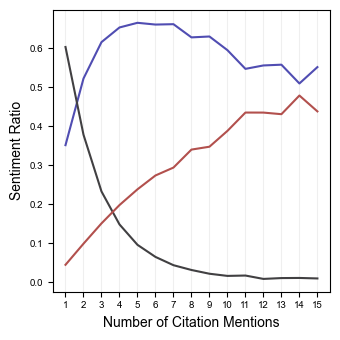

In [4]:
# Figure production.
fig, ax = plt.subplots(figsize=(3.41, 3.41))
xticklabels = [f"{x}" for x in range(1, cm_max + 1)]  # Number of citation mentions label.
x_arr = np.arange(len(xticklabels))

for i in range(3):  # One curve for each of the 3 sentiments.
    ax.plot(x_arr, ratio_mat_rel[:, i], color=sent_colors[i])

ax.set_xlabel("Number of Citation Mentions", size=10)  # x-large
ax.set_ylabel("Sentiment Ratio", size=10)  # x-large
ax.set_xticks(x_arr, xticklabels)
ax.grid(which="major", axis="x", alpha=0.2)

fig.tight_layout()
plt.show()
fig.savefig(os.path.join(dir_output, "SUPP SR vs. NS.svg"), bbox_inches="tight", transparent=True)
fig.clf()  # Clear figure.
plt.close(fig=fig)  # Close figure.

### Gender difference in self-cite sentiment

In [2]:
from helper_functions import stats, pval_star, plot_scatter_no_fit

ratio_mat_rel = np.load(os.path.join(dir_npy, "ratio_mat_rel-gender_effect.npy"))
ratio_mat_rel = ratio_mat_rel[-1, ...]
genders_select = np.load(os.path.join(dir_npy, "groups-gender_effect.npy"))

sent2lab = {1: "Favorable Sentiment", 0: "Neutral Sentiment", -1: "Critical Sentiment"}
sent2idx = {1: 0, 0: 1, -1: 2}

In [3]:
for sent in [-1, 0, 1]:
    print(f"\n\n{sent2lab[sent]}")
    mean = ratio_mat_rel[:, sent2idx[sent], :]

    t_mean = stats.ttest_ind(mean[0, :], mean[1, :], equal_var=False, permutations=None, alternative="two-sided")
    print(f"mean {np.nanmean(mean[0, :])-np.nanmean(mean[1, :])} {pval_star(t_mean.pvalue)}", t_mean)

    print("Normality tests:")
    for g, g_str in enumerate(genders_select):
        print("mean", g_str, stats.normaltest(mean[g, :]))

    print(f"mean {np.nanmean(mean[0, :]):.2f}, {np.nanmean(mean[1, :]):.2f}")
    print(f"std {np.nanstd(mean[0, :]):.2f}, {np.nanstd(mean[1, :]):.2f}")



Critical Sentiment
mean 5.597755579173615 p<0.0001 TtestResult(statistic=46.85732241370161, pvalue=1.10621653787852e-309, df=1721.9818935879032)
Normality tests:
mean man NormaltestResult(statistic=3.707295967322457, pvalue=0.15666461266810125)
mean woman NormaltestResult(statistic=6.628959325995082, pvalue=0.036352959446849825)
mean -29.33, -34.93
std 2.07, 3.16


Neutral Sentiment
mean -0.5916405371531823 p<0.0001 TtestResult(statistic=-8.898027989381857, pvalue=1.4751305803769033e-18, df=1632.5478031804223)
Normality tests:
mean man NormaltestResult(statistic=2.107084293599074, pvalue=0.34870041094353904)
mean woman NormaltestResult(statistic=1.3899576469905344, pvalue=0.49908501674945016)
mean -20.43, -19.84
std 1.08, 1.80


Favorable Sentiment
mean -0.8146215344712857 p<0.0001 TtestResult(statistic=-11.684457151260668, pvalue=2.2919189742055713e-30, df=1656.8782696441015)
Normality tests:
mean man NormaltestResult(statistic=3.594077179053162, pvalue=0.16578913162810555)
mean wom